# A 2D Infinite Fuel Pin Geometry of the SNRE 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import openmc

openmc.Materials.cross_sections = "/home/jimmy/Documents/SNRE_UROP/SNRE/ICL_UROP/dataLibrary/cross_sections.xml"

# Materials definitions
FE_fuel = openmc.Material(name='FE_fuel', temperature=300)
FE_fuel.set_density('g/cm3', 3.64)
FE_fuel.add_nuclide('U235', 1.5330E-01, 'wo')
FE_fuel.add_nuclide('U238', 1.1538E-02, 'wo')
FE_fuel.add_nuclide('Zr90', 2.5214E-01, 'wo')
FE_fuel.add_nuclide('Zr91', 5.5597E-02, 'wo')
FE_fuel.add_nuclide('Zr92', 8.5916E-02, 'wo')
FE_fuel.add_nuclide('Zr94', 8.8964E-02, 'wo')
FE_fuel.add_nuclide('Zr96', 1.4638E-02, 'wo')
FE_fuel.add_nuclide('C0', 3.3791E-01, 'wo')
FE_fuel.add_s_alpha_beta('c_Graphite')

FE_coolant = openmc.Material(name='FE_coolant', temperature=300)
FE_coolant.set_density('g/cm3', 2.7002E-03)
FE_coolant.add_nuclide('H1', 9.9977E-01, 'wo')
FE_coolant.add_nuclide('H2', 2.2980E-04, 'wo')

FE_cladding = openmc.Material(name='FE_claddingOuter', temperature=300)
FE_cladding.set_density('g/cm3', 6.73)
FE_cladding.add_nuclide('Zr90', 4.4811E-01, 'wo')
FE_cladding.add_nuclide('Zr91', 9.8811E-02, 'wo')
FE_cladding.add_nuclide('Zr92', 1.5269E-01, 'wo')
FE_cladding.add_nuclide('Zr94', 1.5811E-01, 'wo')
FE_cladding.add_nuclide('Zr96', 2.6016E-02, 'wo')
FE_cladding.add_nuclide('C0', 1.1625E-01, 'wo')
FE_cladding.add_s_alpha_beta('c_Graphite')

# Materials xml
materials = openmc.Materials([FE_fuel, FE_coolant, FE_cladding])
materials.export_to_xml('./xmlFiles/')

# Geometry definitions
channelRadius = 0.11827
cladOuterRadius = 0.12827
pinPitch = 0.40894
subassemblyDuctOuter = 1.905
subassemblyDuctThickness = 0.005
subassemblyDuctInner = subassemblyDuctOuter - 2*subassemblyDuctThickness

# Boudaries and outer universe
fuelOut = openmc.Cell(cell_id=200, fill=FE_fuel)

# Inner Hexagon
assemblyHex = openmc.hexagonal_prism(edge_length=subassemblyDuctInner / np.sqrt(3.),
                                        orientation='x')

# Outer Hexagon
cladOuterHex = openmc.hexagonal_prism(edge_length=subassemblyDuctOuter / np.sqrt(3.), 
                                         orientation='x',
                                         boundary_type='reflective')

assemblyCell = openmc.Cell()
cladOuterCell = openmc.Cell()
voidCell = openmc.Cell()

assemblyCell.region = assemblyHex
cladOuterCell.region = ~assemblyHex & cladOuterHex 
voidCell.region = ~cladOuterHex
cladOuterCell.fill = FE_cladding

# Create universes
fuelOutUni = openmc.Universe(cells=(fuelOut,))
cladOuterUni = openmc.Universe(cells=[cladOuterCell])
rootUni = openmc.Universe()

coolantChannelOuter = openmc.ZCylinder(surface_id=400, r=channelRadius)
cladChannelOuter = openmc.ZCylinder(surface_id=402, r=cladOuterRadius)

coolantChannelCell  = openmc.Cell(cell_id=400, fill=FE_coolant, region=-coolantChannelOuter)
cladChannelCell  = openmc.Cell(cell_id=401, fill=FE_cladding, region=+coolantChannelOuter & -cladChannelOuter)
fuelChannelCell = openmc.Cell(cell_id=402, fill=FE_fuel, region=+cladChannelOuter)

channelUni = openmc.Universe(cells=[fuelChannelCell, cladChannelCell, coolantChannelCell])

# Creating the hexagonal lattice
lattice=openmc.HexLattice(name='assembly')
lattice.center = (0., 0.)
lattice.pitch = (pinPitch,)
lattice.outer = fuelOutUni
ring2=[channelUni]*12
ring1=[channelUni]*6
ring0=[channelUni]
lattice.universes = [ring2, ring1, ring0]
lattice.orientation='x'
assemblyCell.fill = lattice

rootUni.add_cells([assemblyCell, cladOuterCell, voidCell])
geom=openmc.Geometry(rootUni)
geom.export_to_xml('./xmlFiles/')

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'pixels'

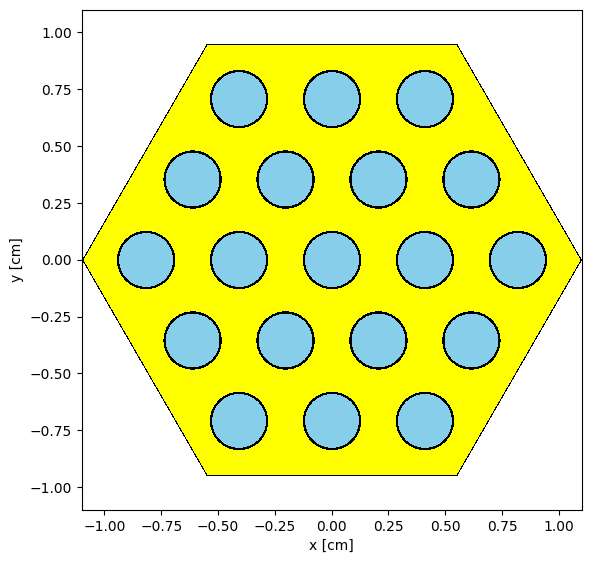

In [43]:
rootUni.plot(origin=(0,0,0),width=(2.2,2.2),color_by='material',colors={FE_fuel: 'yellow', FE_coolant: 'skyblue', FE_cladding: 'black',},pixels=[500,500])
plt.savefig('./pics/2DFuelPin.png',dpi=300)

In [ ]:
# OpenMC simulation parameters

settings = openmc.Settings()
settings.run_mode = 'eigenvalue'

settings.particles = 5000
settings.generations_per_batch = 20
settings.batches = 40
settings.inactive = 20
settings.export_to_xml('./xmlFiles/')

source = openmc.IndependentSource()
source.space = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))

tallies = openmc.Tallies()

FE_fuelThermalTally = openmc.Tally(tally_id=1)
FE_fuelThermalTally.filters = [openmc.EnergyFilter([0,0.625]), openmc.MaterialFilter([FE_fuel])]
FE_fuelThermalTally.scores = ['absorption', 'fission']
tallies.append(FE_fuelThermalTally)

FE_fuelFastTally = openmc.Tally(tally_id=4)
FE_fuelFastTally.filters = [openmc.EnergyFilter([0.625,19.6403e6]), openmc.MaterialFilter([FE_fuel])]
FE_fuelFastTally.scores = ['absorption', 'fission']
tallies.append(FE_fuelFastTally)

FE_coolantThermalTally = openmc.Tally(tally_id=2)
FE_coolantThermalTally.filters = [openmc.EnergyFilter([0,0.625]), openmc.MaterialFilter([FE_coolant])]
FE_coolantThermalTally.scores = ['absorption']
tallies.append(FE_coolantThermalTally)

FE_coolantFastTally = openmc.Tally(tally_id=5)
FE_coolantFastTally.filters = [openmc.EnergyFilter([0.625,19.6403e6]), openmc.MaterialFilter([FE_coolant])]
FE_coolantFastTally.scores = ['absorption']
tallies.append(FE_coolantFastTally)

FE_claddingThermalTally = openmc.Tally(tally_id=3)
FE_claddingThermalTally.filters = [openmc.EnergyFilter([0,0.625]), openmc.MaterialFilter([FE_cladding])]
FE_claddingThermalTally.scores = ['absorption']
tallies.append(FE_claddingThermalTally)

FE_claddingFastTally = openmc.Tally(tally_id=6)
FE_claddingFastTally.filters = [openmc.EnergyFilter([0.625,19.6403e6]), openmc.MaterialFilter([FE_cladding])]
FE_claddingFastTally.scores = ['absorption']
tallies.append(FE_claddingFastTally)

tallies.export_to_xml('./xmlFiles/')

openmc.run(path_input='./xmlFiles/')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=4.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=5.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=3.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=6.
  warn(msg, IDWarning)
/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Filter 

RuntimeError: Material XML file './xmlFiles/materials.xml' does not exist.

In [ ]:
with openmc.StatePoint('statepoint.{}.h5'.format(settings.batches)) as sp:
    k_combined = sp.k_combined
    k_generation = sp.k_generation
    with open('./txtFiles/k_combined.txt', 'w') as f:
        f.write("{}\n".format(k_combined))
    with open('./txtFiles/k_generation.txt', 'w') as f:
        for value in k_generation:
            f.write("{}\n".format(value))

    FE_fuelThermalTallyOutput = sp.get_tally(id=1)
    df_FE_fuelThermal = FE_fuelThermalTallyOutput.get_pandas_dataframe()
    df_FE_fuelThermalAbsorption = df_FE_fuelThermal[df_FE_fuelThermal['score'] == 'absorption']
    df_FE_fuelThermalFission = df_FE_fuelThermal[df_FE_fuelThermal['score'] == 'fission']

    FE_fuelFastTallyOutput = sp.get_tally(id=4)
    df_FE_fuelFast = FE_fuelFastTallyOutput.get_pandas_dataframe()
    df_FE_fuelFastAbsorption = df_FE_fuelFast[df_FE_fuelFast['score'] == 'absorption']
    df_FE_fuelFastFission = df_FE_fuelFast[df_FE_fuelFast['score'] == 'fission']

    FE_coolantThermalTallyOutput = sp.get_tally(id=2)
    df_FE_coolantThermal = FE_coolantThermalTallyOutput.get_pandas_dataframe()
    df_FE_coolantThermalAbsorption = df_FE_coolantThermal[df_FE_coolantThermal['score'] == 'absorption']

    FE_coolantFastTallyOutput = sp.get_tally(id=5)
    df_FE_coolantFast = FE_coolantFastTallyOutput.get_pandas_dataframe()
    df_FE_coolantFastAbsorption = df_FE_coolantFast[df_FE_coolantFast['score'] == 'absorption']

    FE_claddingThermalTallyOutput = sp.get_tally(id=3)
    df_FE_claddingThermal = FE_claddingThermalTallyOutput.get_pandas_dataframe()
    df_FE_claddingThermalAbsorption = df_FE_claddingThermal[df_FE_claddingThermal['score'] == 'absorption']

    FE_claddingFastTallyOutput = sp.get_tally(id=6)
    df_FE_claddingFast = FE_claddingFastTallyOutput.get_pandas_dataframe()
    df_FE_claddingFastAbsorption = df_FE_claddingFast[df_FE_claddingFast['score'] == 'absorption']

    print('Fuel Thermal Absorption: {:.6e}'.format(float(df_FE_fuelThermalAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelThermalAbsorption['std. dev.'])))
    print('Fuel Thermal Fission: {:.6e}'.format(float(df_FE_fuelThermalFission['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelThermalFission['std. dev.'])))
    print('Fuel Fast Absorption: {:.6e}'.format(float(df_FE_fuelFastAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelFastAbsorption['std. dev.'])))
    print('Fuel Fast Fission: {:.6e}'.format(float(df_FE_fuelFastFission['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelFastFission['std. dev.'])))
    print('Coolant Thermal Absorption: {:.6e}'.format(float(df_FE_coolantThermalAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_coolantThermalAbsorption['std. dev.'])))
    print('Coolant Fast Absorption: {:.6e}'.format(float(df_FE_coolantFastAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_coolantFastAbsorption['std. dev.'])))
    print('Cladding Thermal Absorption: {:.6e}'.format(float(df_FE_claddingThermalAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_claddingThermalAbsorption['std. dev.'])))
    print('Cladding Fast Absorption: {:.6e}'.format(float(df_FE_claddingFastAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_claddingFastAbsorption['std. dev.'])))

Fuel Thermal Absorption: 3.847392e-03 ± 5.049296e-05
Fuel Thermal Fission: 3.275181e-03 ± 4.214005e-05
Fuel Fast Absorption: 9.841698e-01 ± 6.296055e-04
Fuel Fast Fission: 6.563880e-01 ± 3.757190e-04
Coolant Thermal Absorption: 1.112457e-06 ± 1.241018e-08
Coolant Fast Absorption: 5.474528e-05 ± 6.464365e-08
Cladding Thermal Absorption: 3.168978e-06 ± 3.722504e-08
Cladding Fast Absorption: 1.354780e-02 ± 1.518142e-05


/home/jimmy/.local/lib/python3.10/site-packages/openmc/statepoint.py:277: FutureWarning: The 'k_combined' property has been renamed to 'keff' and will be removed in a future version of OpenMC.
  warnings.warn(
/tmp/ipykernel_25182/1535854804.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Fuel Thermal Absorption: {:.6e}'.format(float(df_FE_fuelThermalAbsorption['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelThermalAbsorption['std. dev.'])))
/tmp/ipykernel_25182/1535854804.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Fuel Thermal Fission: {:.6e}'.format(float(df_FE_fuelThermalFission['mean'])), u'\u00B1 {:.6e}'.format(float(df_FE_fuelThermalFission['std. dev.'])))
/tmp/ipykernel_25182/1535854804.py:38: FutureWarning: Calling float on a single element Series is d